# Noise and Removal Techniques

<pre>
i. Using OpenCV import a colour image and convert the same to its grey scale equivalent.
ii. Understand the impact of different types on noise in images (Gaussian, Salt & Pepper, Poisson, Spectacle) by introducing different types of noise to images. 
iii. Identify different filters (Gaussian, Median, Mean and Weiner) that might suppress the different types of noise in images. 
iv. Through experimentation, determine, which filter is best suited for suppressing each type of noise present in an image.
</pre>

# Kaggle Dataset

## Drive Connection

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


## Get key

In [ ]:
!mkdir /root/.kaggle/
!cp /drive/MyDrive/kaggle.json /root/.kaggle/

## Download dataset

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 2.4 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=ed23c44844b14ad5c0307d265e5abfeaa98df03d67ca7f906155d849f0ff486a
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [03:44<00:00, 57.8MB/s]
100% 9.51G/9.51G [03:44<00:00, 45.5MB/s]


In [ ]:
!unzip -qq aptos2019-blindness-detection.zip

# Get image to work on from dataset

In [ ]:
# get file name
import os

IMAGE_DIR = "train_images"
IMAGE_NAME = os.listdir(IMAGE_DIR)[0]
print(IMAGE_NAME)

e9ff9352ccb3.png


# Get image from web

In [ ]:
!wget https://media.wired.com/photos/5c523ece95d28a2cb5b76db1/1:1/w_494,h_494,c_limit/Backchannel-Lena-Soderberg-FA.jpg -O image.jpg
IMAGE_DIR = ""
IMAGE_NAME = "image.jpg"

--2022-01-13 17:20:17--  https://media.wired.com/photos/5c523ece95d28a2cb5b76db1/1:1/w_494,h_494,c_limit/Backchannel-Lena-Soderberg-FA.jpg
Resolving media.wired.com (media.wired.com)... 151.101.0.239, 151.101.64.239, 151.101.128.239, ...
Connecting to media.wired.com (media.wired.com)|151.101.0.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54209 (53K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  52.94K  --.-KB/s    in 0.008s  

2022-01-13 17:20:17 (6.58 MB/s) - ‘image.jpg’ saved [54209/54209]



# Loading and resizing image

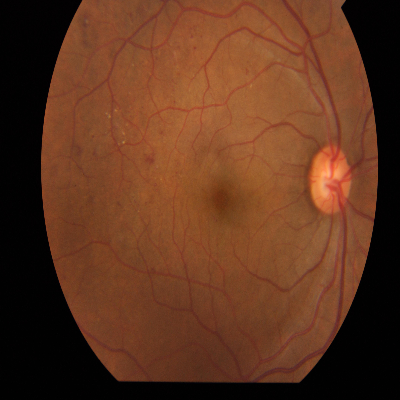

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

IMG_ORIGINAL = cv2.imread(os.path.join(IMAGE_DIR, IMAGE_NAME))

MAX_PIXEL = 255

# resize for better visibility
IMAGE_SIZE = (400, 400)
IMG = cv2.resize(IMG_ORIGINAL, IMAGE_SIZE)
cv2_imshow(IMG)

# Grayscale image

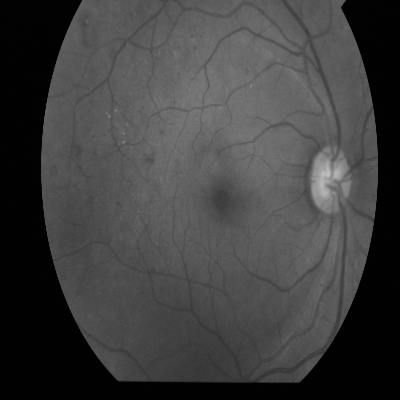

In [ ]:
IMG_GRAY = cv2.cvtColor(IMG, cv2.COLOR_BGR2GRAY)
cv2_imshow(IMG_GRAY)

# Noise functions
Credits to <a href="https://stackoverflow.com/a/30609854/7258547" target="_blank">this</a> stackoverflow answer.

In [ ]:
import numpy as np

def noisy_gauss(image, var=0.1):
  mean = 0
  sigma = var**0.5
  if len(image.shape)==3 :
    row,col,ch = image.shape
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
  else :
    row,col = image.shape
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
  noisy = image + gauss
  return noisy

def noisy_sp(image, s_vs_p=0.5, amount=0.004):
  out = np.copy(image)
  # Salt mode
  num_salt = np.ceil(amount * image.size * s_vs_p)
  coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
  out[tuple(coords)] = 1
  # Pepper mode
  num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
  coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
  out[tuple(coords)] = 0
  return out

def noisy_poisson(image):
  vals = len(np.unique(image))
  vals = 2 ** np.ceil(np.log2(vals))
  noisy = np.random.poisson(image * vals) / float(vals)
  return noisy
  
def noisy_speckle(image):
  if len(image.shape)==3 :
    row,col,ch = image.shape
    gauss = np.random.randn(row,col,ch)
    gauss = gauss.reshape(row,col,ch) 
  else :
    row,col = image.shape
    gauss = np.random.randn(row,col)
    gauss = gauss.reshape(row,col) 
  noisy = image + image * gauss
  return noisy

# Side by side printer

In [ ]:
def h_printer(*images):
  return cv2.hconcat([img.astype('int32') for img in images])

# Noises

## Gaussian Noise

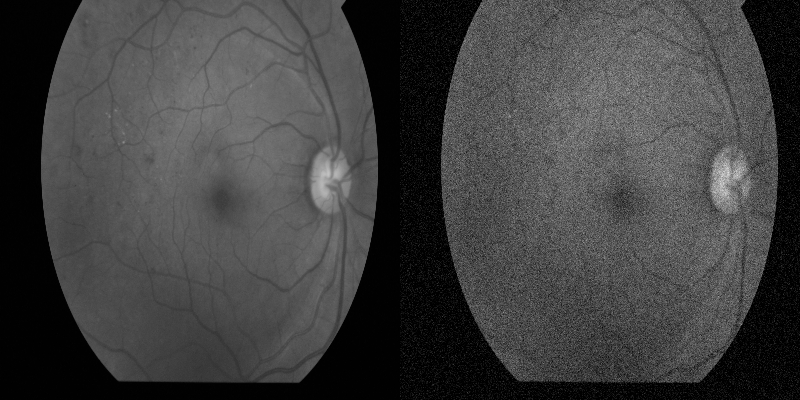

In [ ]:
IMAGE_GAUSSIAN = noisy_gauss(IMG_GRAY, var=MAX_PIXEL)
cv2_imshow(h_printer(IMG_GRAY,IMAGE_GAUSSIAN))

## Salt and Pepper Noise

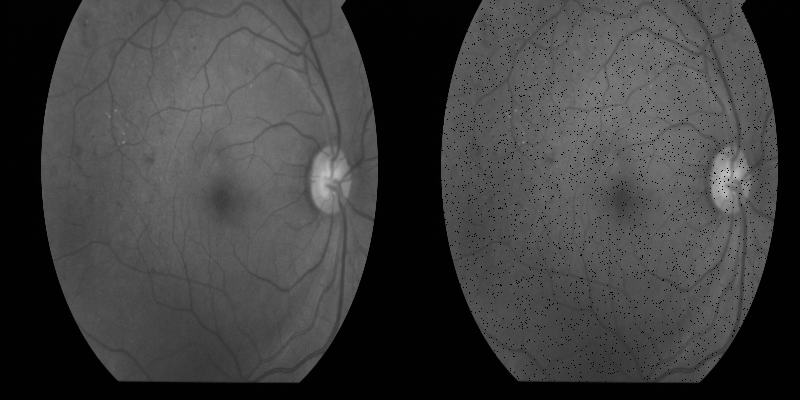

In [ ]:
IMAGE_SALT_PEPPER = noisy_sp(IMG_GRAY, s_vs_p=0.5, amount=0.025)
cv2_imshow(h_printer(IMG_GRAY,IMAGE_SALT_PEPPER))

## Poisson Noise

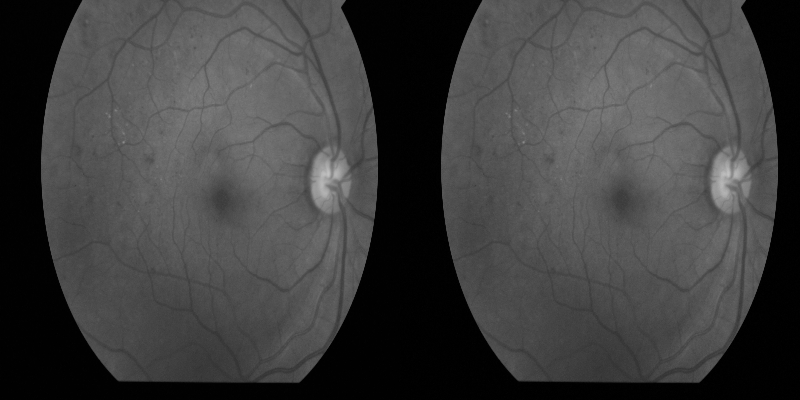

In [ ]:
IMAGE_POISSON = noisy_poisson(IMG_GRAY)
cv2_imshow(h_printer(IMG_GRAY,IMAGE_POISSON))

## Speckle Noise

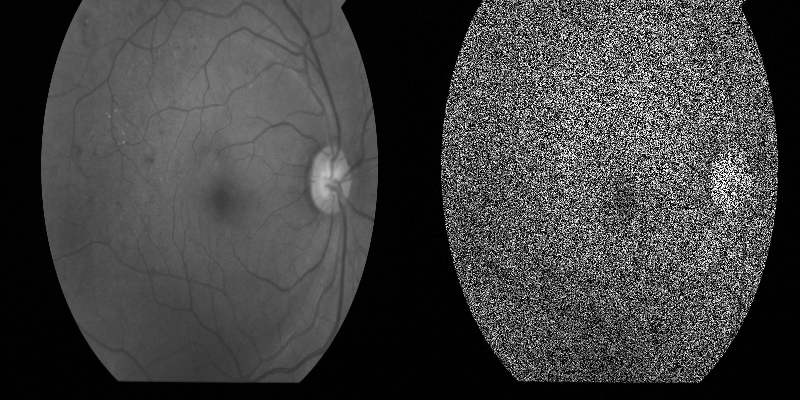

In [ ]:
IMAGE_SPECKLE = noisy_speckle(IMG_GRAY)
cv2_imshow(h_printer(IMG_GRAY,IMAGE_SPECKLE))

# Filter funtions

In [ ]:
from scipy.signal.signaltools import wiener

def filter_gaussian(image, kernel_size=5, var=0.01):
  sigma = var**0.5
  return cv2.GaussianBlur(image,(kernel_size,kernel_size), sigma, sigma)

def filter_median(image, kernel_size=5):
  return cv2.medianBlur(np.float32(image),kernel_size)

def filter_mean(image, kernel_size=5):
  return cv2.blur(np.float32(image),(kernel_size, kernel_size))

def filter_wiener(image, kernel_size=5):
  return wiener(image, (kernel_size, kernel_size))

# Filter Trials

## Gaussian Noise

### Gaussian Noise vs Gaussian Filter

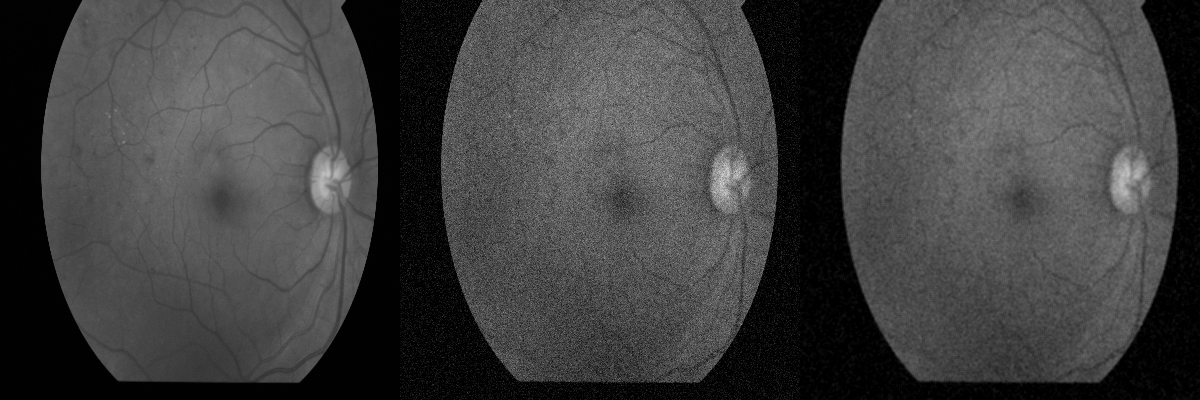

In [ ]:
IMAGE_GAUSSIAN_FILTER_GAUSSIAN = filter_gaussian(IMAGE_GAUSSIAN, kernel_size=3, var=MAX_PIXEL)
cv2_imshow(h_printer(IMG_GRAY, IMAGE_GAUSSIAN, IMAGE_GAUSSIAN_FILTER_GAUSSIAN))

### Gaussian Noise vs Median Filter

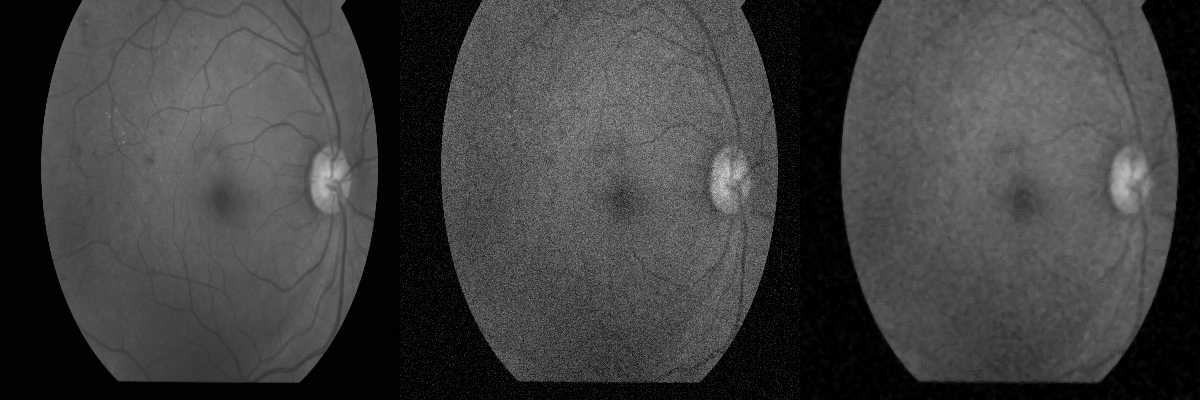

In [ ]:
IMAGE_GAUSSIAN_FILTER_MEDIAN = filter_median(IMAGE_GAUSSIAN, kernel_size=5)
cv2_imshow(h_printer(IMG_GRAY, IMAGE_GAUSSIAN, IMAGE_GAUSSIAN_FILTER_MEDIAN))

### Gaussian Noise vs Mean Filter

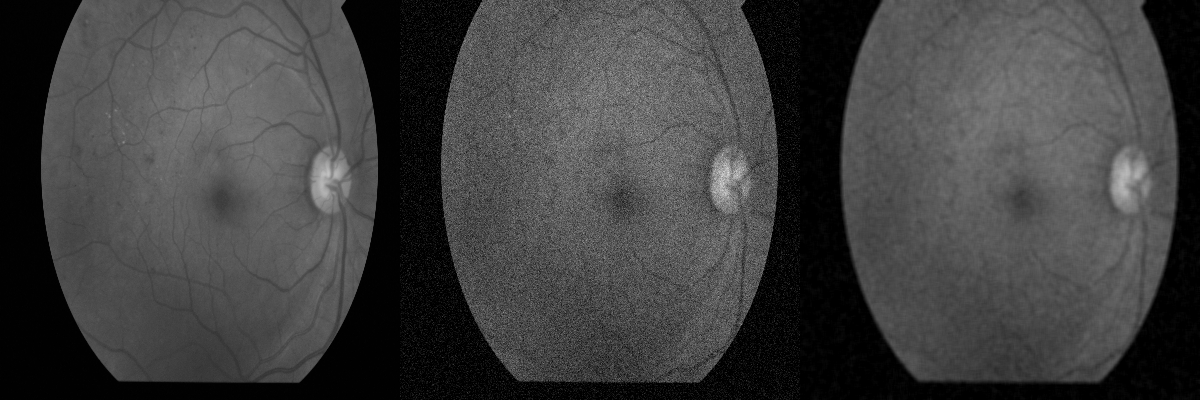

In [ ]:
IMAGE_GAUSSIAN_FILTER_AVERAGE = filter_mean(IMAGE_GAUSSIAN, kernel_size=5)
cv2_imshow(h_printer(IMG_GRAY, IMAGE_GAUSSIAN, IMAGE_GAUSSIAN_FILTER_AVERAGE))

### Gaussian Noise vs Weiner Filter

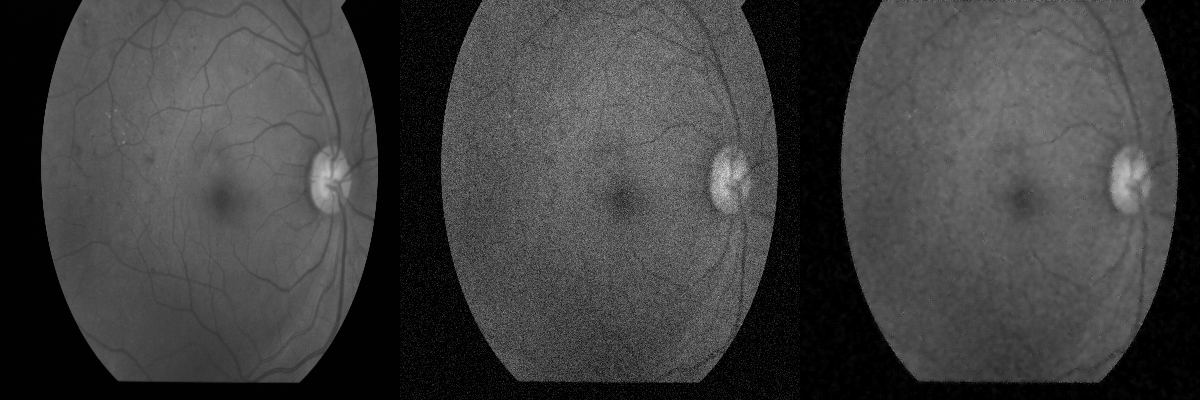

In [ ]:
IMAGE_GAUSSIAN_FILTER_WIENER = filter_wiener(IMAGE_GAUSSIAN, kernel_size=5)
cv2_imshow(h_printer(IMG_GRAY, IMAGE_GAUSSIAN, IMAGE_GAUSSIAN_FILTER_WIENER))

## Salt and Pepper Noise

### Salt and Pepper Noise vs Gaussian Filter

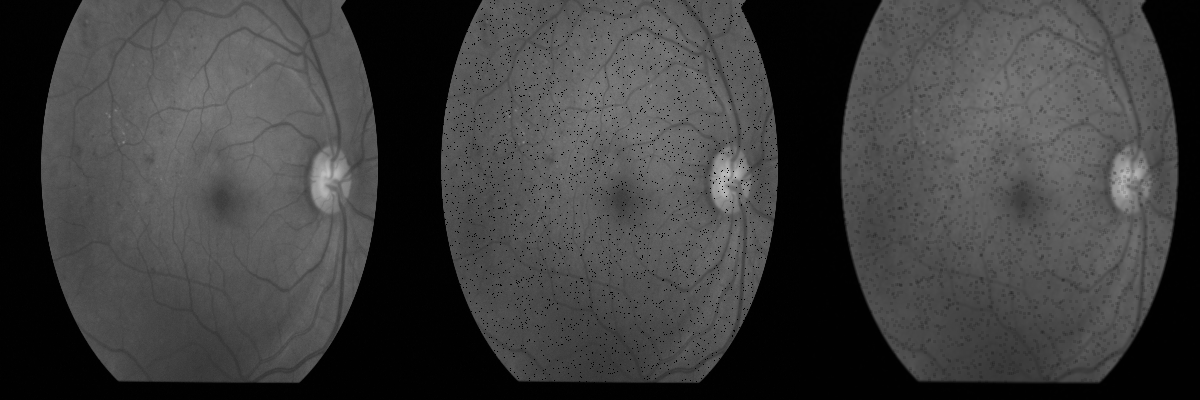

In [ ]:
IMAGE_SALT_PEPPER_FILTER_GAUSSIAN = filter_gaussian(IMAGE_SALT_PEPPER, kernel_size=3, var=MAX_PIXEL)
cv2_imshow(h_printer(IMG_GRAY, IMAGE_SALT_PEPPER, IMAGE_SALT_PEPPER_FILTER_GAUSSIAN))

### Salt and Pepper Noise vs Median Filter

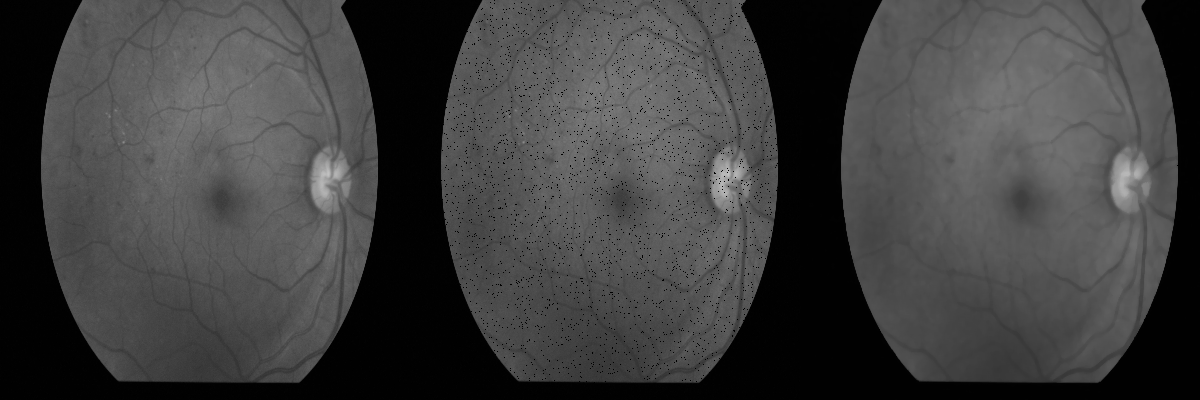

In [ ]:
IMAGE_SALT_PEPPER_FILTER_MEDIAN = filter_median(IMAGE_SALT_PEPPER, kernel_size=5)
cv2_imshow(h_printer(IMG_GRAY, IMAGE_SALT_PEPPER, IMAGE_SALT_PEPPER_FILTER_MEDIAN))

### Salt and Pepper Noise vs Mean Filter

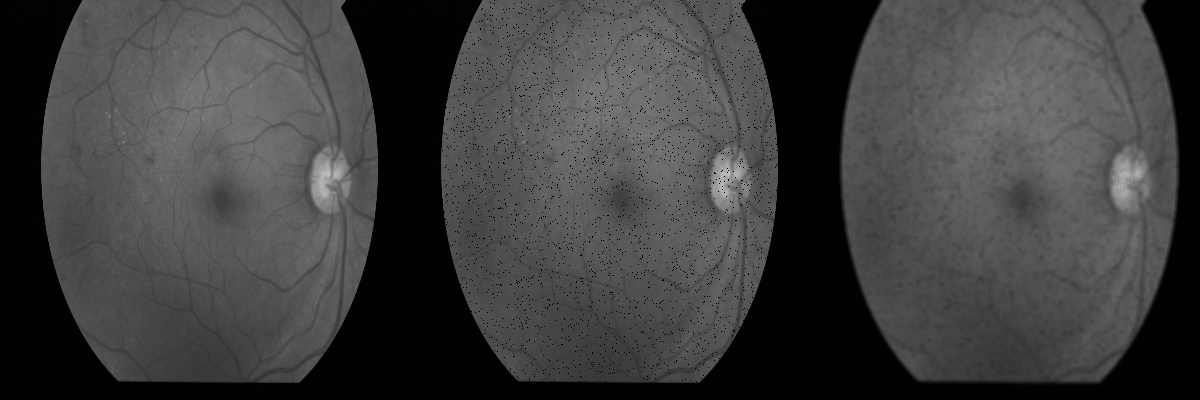

In [ ]:
IMAGE_SALT_PEPPER_FILTER_AVERAGE = filter_mean(IMAGE_SALT_PEPPER, kernel_size=5)
cv2_imshow(h_printer(IMG_GRAY, IMAGE_SALT_PEPPER, IMAGE_SALT_PEPPER_FILTER_AVERAGE))

### Salt and Pepper Noise vs Weiner Filter

/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


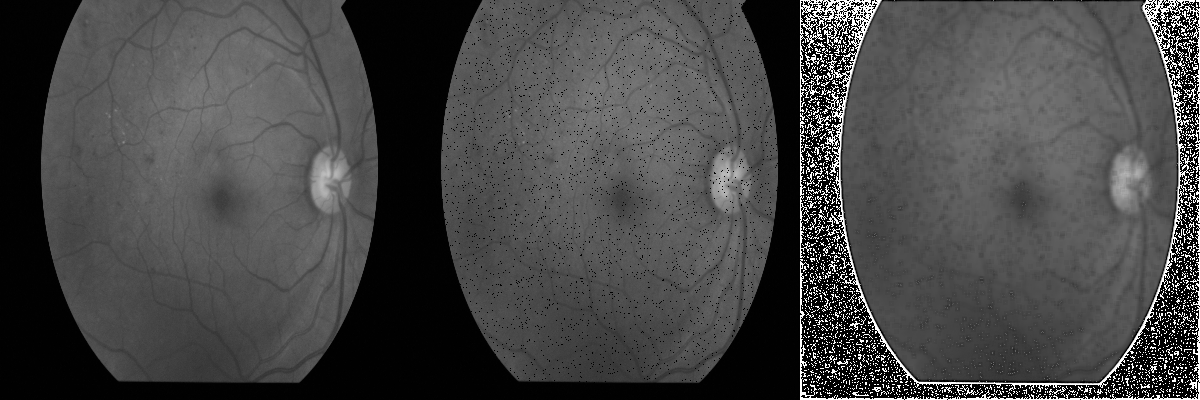

In [ ]:
IMAGE_SALT_PEPPER_FILTER_WIENER = filter_wiener(IMAGE_SALT_PEPPER, kernel_size=5)
cv2_imshow(h_printer(IMG_GRAY, IMAGE_SALT_PEPPER, IMAGE_SALT_PEPPER_FILTER_WIENER))

## Poisson Noise

### Poisson Noise vs Gaussian Filter

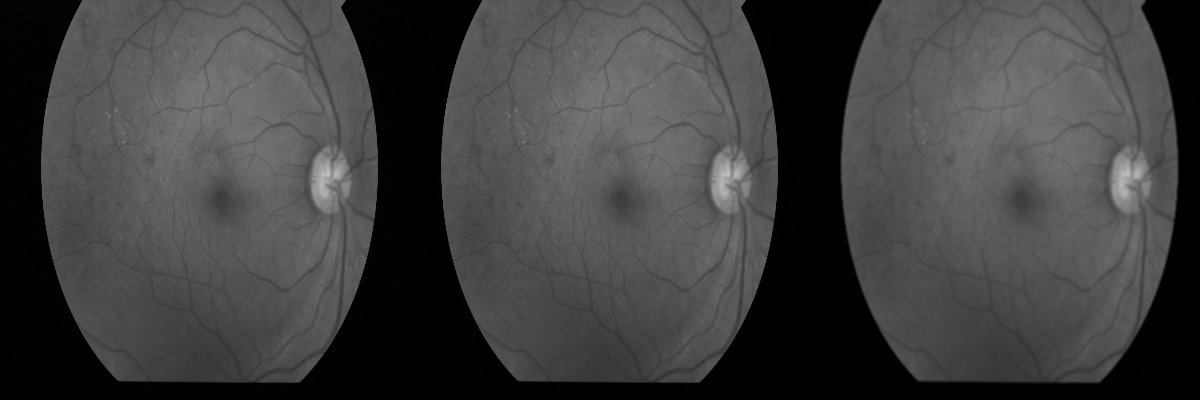

In [ ]:
IMAGE_POISSON_FILTER_GAUSSIAN = filter_gaussian(IMAGE_POISSON, kernel_size=3, var=MAX_PIXEL)
cv2_imshow(h_printer(IMG_GRAY, IMAGE_POISSON, IMAGE_POISSON_FILTER_GAUSSIAN))

### Poisson Noise vs Median Filter

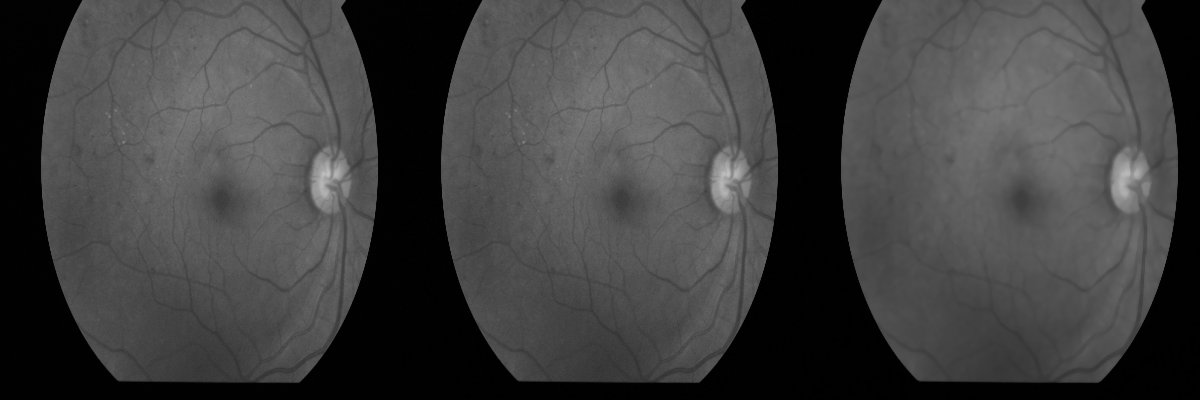

In [ ]:
IMAGE_POISSON_FILTER_MEDIAN = filter_median(IMAGE_POISSON, kernel_size=5)
cv2_imshow(h_printer(IMG_GRAY, IMAGE_POISSON, IMAGE_POISSON_FILTER_MEDIAN))

### Poisson Noise vs Mean Filter

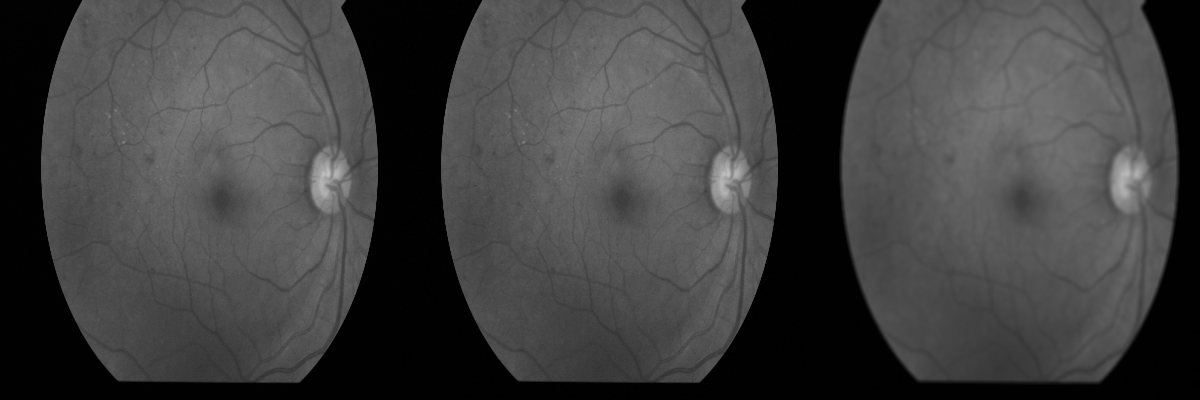

In [ ]:
IMAGE_POISSON_FILTER_AVERAGE = filter_mean(IMAGE_POISSON, kernel_size=5)
cv2_imshow(h_printer(IMG_GRAY, IMAGE_POISSON, IMAGE_POISSON_FILTER_AVERAGE))

### Poisson Noise vs Weiner Filter

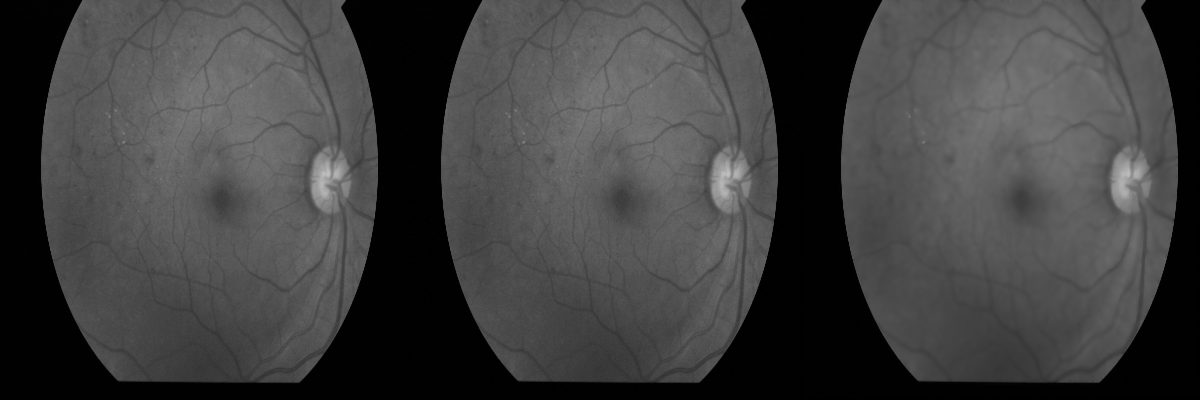

In [ ]:
IMAGE_POISSON_FILTER_WIENER = filter_wiener(IMAGE_POISSON, kernel_size=5)
cv2_imshow(h_printer(IMG_GRAY, IMAGE_POISSON, IMAGE_POISSON_FILTER_WIENER))

## Speckle Noise

### Speckle Noise vs Gaussian Filter

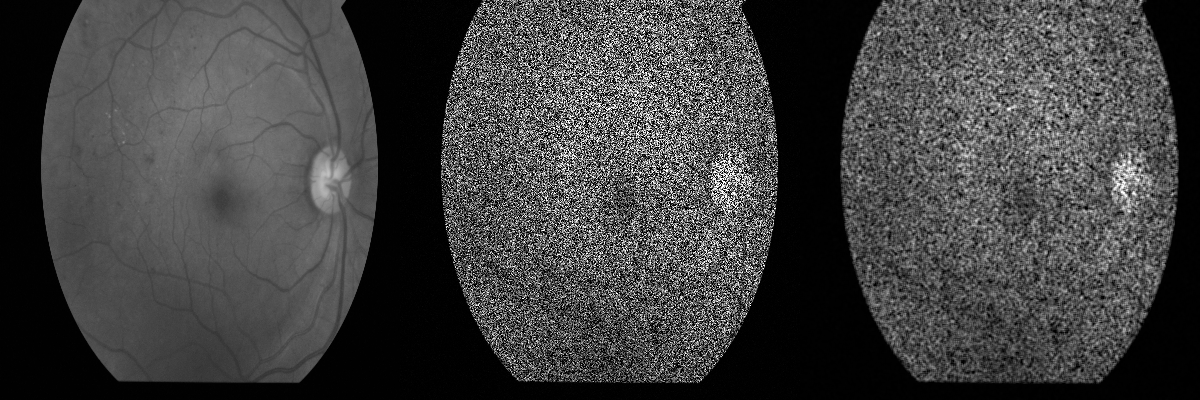

In [ ]:
IMAGE_SPECKLE_FILTER_GAUSSIAN = filter_gaussian(IMAGE_SPECKLE, kernel_size=3, var=MAX_PIXEL)
cv2_imshow(h_printer(IMG_GRAY, IMAGE_SPECKLE, IMAGE_SPECKLE_FILTER_GAUSSIAN))

### Speckle Noise vs Median Filter

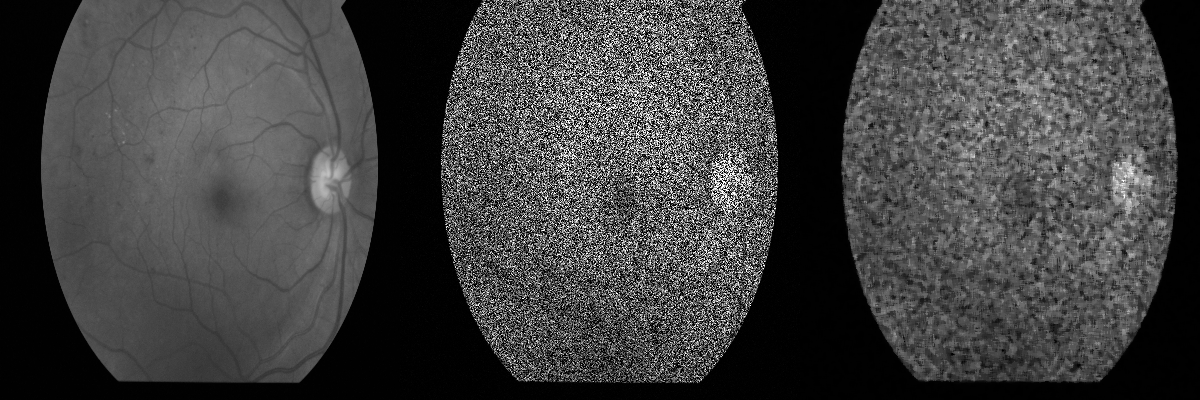

In [ ]:
IMAGE_SPECKLE_FILTER_MEDIAN = filter_median(IMAGE_SPECKLE, kernel_size=5)
cv2_imshow(h_printer(IMG_GRAY, IMAGE_SPECKLE, IMAGE_SPECKLE_FILTER_MEDIAN))

### Speckle Noise vs Mean Filter

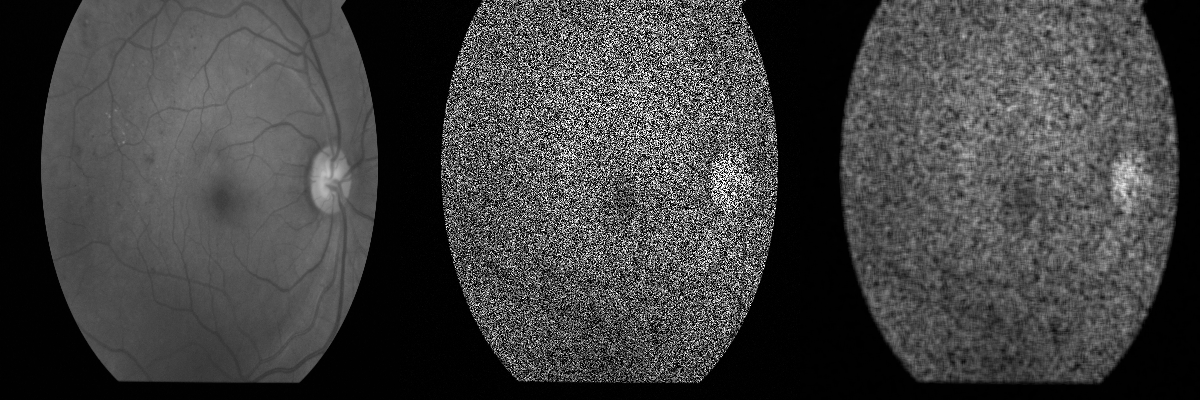

In [ ]:
IMAGE_SPECKLE_FILTER_AVERAGE = filter_mean(IMAGE_SPECKLE, kernel_size=5)
cv2_imshow(h_printer(IMG_GRAY, IMAGE_SPECKLE, IMAGE_SPECKLE_FILTER_AVERAGE))

### Speckle Noise vs Weiner Filter

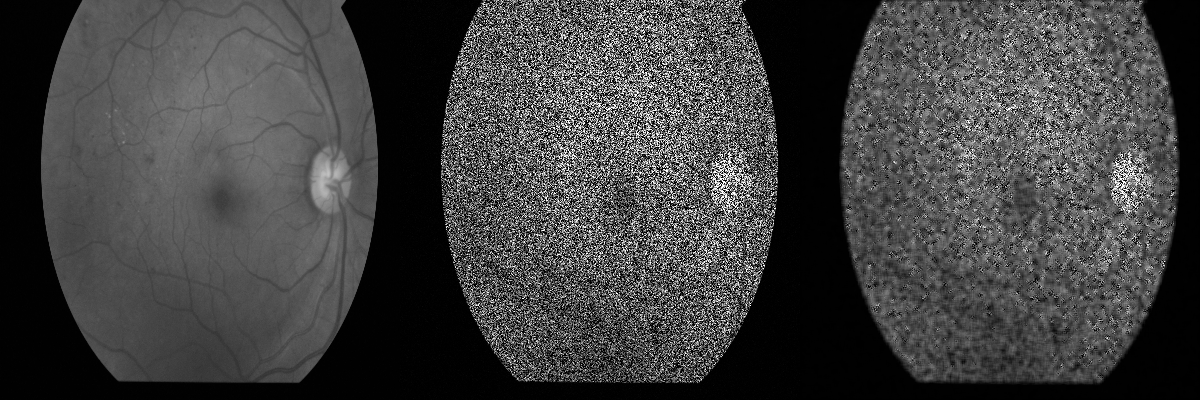

In [ ]:
IMAGE_SPECKLE_FILTER_WIENER = filter_wiener(IMAGE_SPECKLE, kernel_size=5)
cv2_imshow(h_printer(IMG_GRAY, IMAGE_SPECKLE, IMAGE_SPECKLE_FILTER_WIENER))